# Connectionism
In this assignment, you will implement a connectionist model of memory storage and retrieval. Before starting work on the assigment, you should read the following paper:

- McClelland, J. L. (1981). Retrieving general and specific knowledge from stored knowledge of specifics. *Proceedings of the Third Annual Conference of the Cognitive Science Society,* 170-172. [[link]](https://stanford.edu/~jlmcc/papers/McClelland81.pdf)

Note that all example images in this Colab notebook are just that: example images. Your data can lead to different figures and conclusions than the data used to create these examples.

<figure>
<img src="https://web.stanford.edu/group/pdplab/pdphandbook/jetsdiagram.png" alt="Frequency plot" width=400>
</figure>



In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Part 1. Preparing your data and setting up the network

The dataset listed in the paper consists of 27 gang members with each 6 attributes:


1.   Name (27 unique names)
2.   Gang (2 gangs)
3.   Age (3 age brackets)
4.   Education level (3 education levels)
5.   Marital status (3 marital statuses)
6.   Occupation (3 occupations)

This means that the total number of nodes in our network is $27+27+2+3+3+3+3=68$. Nodes are either excitatory or inhibitory connected to each other. We know from the paper that nodes *within* an attribute inhibit each other. Using a $68 \times 68$ matrix we can encode the complete dataset. To save you time, we are providing a binary matrix as a CSV file, indicating whether or not there is an *excitatory* connection between two nodes.

### Assignment 1.1
Load the data and take a look at its contents. The input is represented as a matrix of size $68 \times 68$. Note that [name]-name refers to a property node, while [name] refers to an instance node.

### Assignment 1.2
Now you will need to represent inhibitory connections between property nodes. Think about your design choices.




In [2]:
#!wget -qO dataset.csv https://surfdrive.surf.nl/files/index.php/s/vxOY3pFjSnP5KoQ/download

#Load the dataset
data = pd.read_csv('dataset.csv', header = None)

#Information about dataset
print("===== First 5 rows of dataset.csv =====")
print(data.head())
print(f"Data shape: {data.shape}")

#Extract node names from first column, skip first row
print("\n===== Node Information =====")
node_names = list(data.iloc[1: ,0])
print(f"Total nodes: {len(node_names)}")
for i in range(len(node_names)):
    print(f"{i}: {node_names[i]}")

# Extract the excitatory matrix (only the values)
excitatory_matrix = data.iloc[1:,1:].values.astype(int)
print("\n===== Excitatory_matrix =====")
print(excitatory_matrix)
print(f"Data shape: {excitatory_matrix.shape}")
print("Number of excitatory connections (non-zero):", np.count_nonzero(excitatory_matrix))


# We define the inihibitory groups, i.e. those who are in the same category (age, gang, etc.)
inhibitory_groups = {
    "name_instance" : list(range(0,27)),
    "gang": list(range(27,29)),
    "age" : list(range(29,32)),
    "education" : list(range(32,35)),
    "marital_status" : list(range(35,38)),
    "occupation" : list(range(38,41)),
    "name_property": list(range(41,68))
}

# Create the inhibitory matrix
inhibitory_matrix = np.zeros((68,68),dtype=int)
for group in inhibitory_groups.values():
    for i in group:
        for j in group:
            if i != j:
                inhibitory_matrix[i,j] = 1

print("\n===== Inhibitory_matrix =====")
print(inhibitory_matrix)
print(f"Data shape: {inhibitory_matrix.shape}")

===== First 5 rows of dataset.csv =====
      0    1   2    3      4     5    6     7     8     9   ...         59  \
0    NaN  Art  Al  Sam  Clyde  Mike  Jim  Greg  John  Doug  ...  Nick-name   
1    Art    0   0    0      0     0    0     0     0     0  ...          0   
2     Al    0   0    0      0     0    0     0     0     0  ...          0   
3    Sam    0   0    0      0     0    0     0     0     0  ...          0   
4  Clyde    0   0    0      0     0    0     0     0     0  ...          0   

         60        61         62        63         64         65       66  \
0  Don-name  Ned-name  Karl-name  Ken-name  Earl-name  Rick-name  Ol-name   
1         0         0          0         0          0          0        0   
2         0         0          0         0          0          0        0   
3         0         0          0         0          0          0        0   
4         0         0          0         0          0          0        0   

          67         68  
0 

### Assignment 1.3
It is now time to implement the network as a class named `IACModel`. The class should contain two methods `update_activations()` and `run()` in addition to its special method `__init__()`. You do not yet have to implement the two methods, you will do that later, but you do have to implement `__init__()`. What would you put in there?


In [3]:
#Define the IACModel Class
class IACModel:
    def __init__(self, excitatory_matrix, inhibitory_matrix, resting_activation=0.1, decay_parameter=0.05, initial_activation = 0.1, excitatory_weight = 0.05, inhibitory_weight = 0.03):

        self.excitatory_matrix = excitatory_matrix
        self.inhibitory_matrix = inhibitory_matrix
        self.num_nodes = excitatory_matrix.shape[0]
        self.activations =np.full(self.num_nodes, initial_activation)
        self.resting_activation = resting_activation
        self.decay_parameter = decay_parameter
        self.excitatory_weight = excitatory_weight
        self.inhibitory_weight = inhibitory_weight
        self.max_activation = 1.0
        self.min_activation = -0.2

    def update_activations(self):
        pass

    def run(self):
        pass

## Part 2. System dynamics

The *dynamics* of a system refer to its changes in state over time. Each node's activation depends on the activations of the nodes that are connected to it through excitatory and inhibitory connections.

But this is not all. A node's activation *decays* over time, according to $D(a_i(t)-R)$ with decay parameter $D$ and resting value $R$. Let's look at how this works.

### Assignment 2.1

Assume $D=0.05$ and $R=0.1$. Start by implementing a node with activation $A = 0.1$ at time $t=0$. Have the node's activation decay according to the above definition. At time $t=5$ you will excite the node by setting its activation to $0.9$. Run 100 timesteps, then plot the activation over time. This should look something like:


<figure>
<img src="https://surfdrive.surf.nl/files/index.php/s/PCFawx2t62kCzkL/download" alt="Frequency plot" width=400>
</figure>



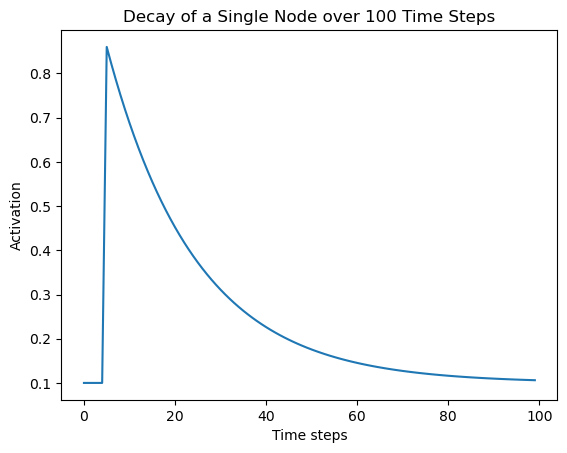

In [4]:
R = 0.1 #Resting value
D = 0.05 #Decay parameter
time_steps = 100
A = 0.1 #initial activation

activation_values = []

for t in range(time_steps):
    if t == 5:
        A = 0.9

    decay = -D * (A-R)
    A += decay
    activation_values.append(A)

plt.plot(activation_values)
plt.xlabel('Time steps')
plt.ylabel('Activation')
plt.title('Decay of a Single Node over 100 Time Steps')
plt.savefig('activation_function.png')
plt.show()


So this is how one node's activation changes over time. Now let's implement our `update_activations()` and `run()` methods to reflect the dynamics described in the paper.

Let's take a look at the paper. Specifically, the net input to node $i$ at time $t$ is given by:

$\textit{input}{_i}(t) = p_i(t) + E\displaystyle\sum_je_{ij}(t) - I\displaystyle\sum_ji_{ij}(t)$

with all necessary symbols explained in the paper (p. 171). In short, the input is determined by (1) the external input going into the system by means of a probe, and (2) the activation of a node's connected neighbors.

Then, once we know $\textit{input}{_i}(t)$, we can calculate $\textit{effect}{_i}(t)$ using this definition from the paper:

<figure>
<img src="https://surfdrive.surf.nl/files/index.php/s/WSFamjOWq6cdU7n/download" alt="Frequency plot" width=600>
</figure>

Finally, we update the activations of our nodes using:

<figure>
<img src="https://surfdrive.surf.nl/files/index.php/s/1RTgbNittDuk46h/download" alt="Frequency plot" width=400>
</figure>

Now you have all the information (together with the paper) to implement the `update_activations()` method in your class. The only thing the `run()` method needs to do is to loop over timesteps (let's say 500) and iteratively call the `update_activations()` method. Implement both.

In [5]:
# your code below
class IACModel:
    def __init__(self, excitatory_matrix, inhibitory_matrix, resting_activation=0.1, decay_parameter=0.05, initial_activation = 0.1, excitatory_weight = 0.05, inhibitory_weight = 0.03):

        self.excitatory_matrix = excitatory_matrix
        self.inhibitory_matrix = inhibitory_matrix
        self.num_nodes = excitatory_matrix.shape[0]
        self.activations =np.full(self.num_nodes, initial_activation)
        self.resting_activation = resting_activation
        self.decay_parameter = decay_parameter
        self.excitatory_weight = excitatory_weight
        self.inhibitory_weight = inhibitory_weight
        self.max_activation = 1.0
        self.min_activation = -0.2

    def update_activations(self, external_input = None):
        if external_input is None:
            external_input = np.zeros(self.num_nodes)

        new_activations = np.copy(self.activations)

        for i in range (self.num_nodes):
            excitatory_input = np.dot(self.excitatory_matrix[i], self.activations)
            inhibitory_input = np.dot(self.inhibitory_matrix[i], self.activations)
            total_input = (external_input[i] + self.excitatory_weight*excitatory_input - self.inhibitory_weight*inhibitory_input)

            # Compute effect based on sign of net input
            if total_input >= 0:
                effect = (self.max_activation - self.activations[i]) * total_input
            else:
                effect = (self.activations[i]-self.min_activation) * total_input

            decay = -self.decay_parameter * (self.activations[i] - self.resting_activation)
            new_activations[i] += effect + decay
            new_activations[i] = np.clip(new_activations[i], self.min_activation, self.max_activation)
        self.activations = new_activations





    def run(self, external_input = None, timesteps = 500):
        activation_values = []
        for t in range(timesteps):
            self.update_activations(external_input)
            activation_values.append(self.activations.copy())
        return np.array(activation_values)


## Part 3. Probing the network and getting information out

For this part, you will create bar graphs of activations. For example, the figure below:


<figure>
<img src="https://surfdrive.surf.nl/files/index.php/s/srMB2wDLzywFo1S/download" alt="Frequency plot" width=400>
</figure>

Let's now take a look at the paper (p. 171) under Examples of the model's behavior.

Probe the network with *Jets*, similar to the paper. Make a figure of the activations of all the property nodes after 500 timesteps.

Now probe the property node of the name *George*. Make a figure of all non-name property nodes.

Finally, probe *Age 20s* and *JH*, similar to the paper. Make a figure showing the activations of the instance nodes.



Activation values for selected nodes after probing 'Jets':

Jets: 0.910
20s: 0.632
JH: 0.714
Single: 0.866
Pusher: 0.651
Burglar: -0.073
Bookie: 0.772


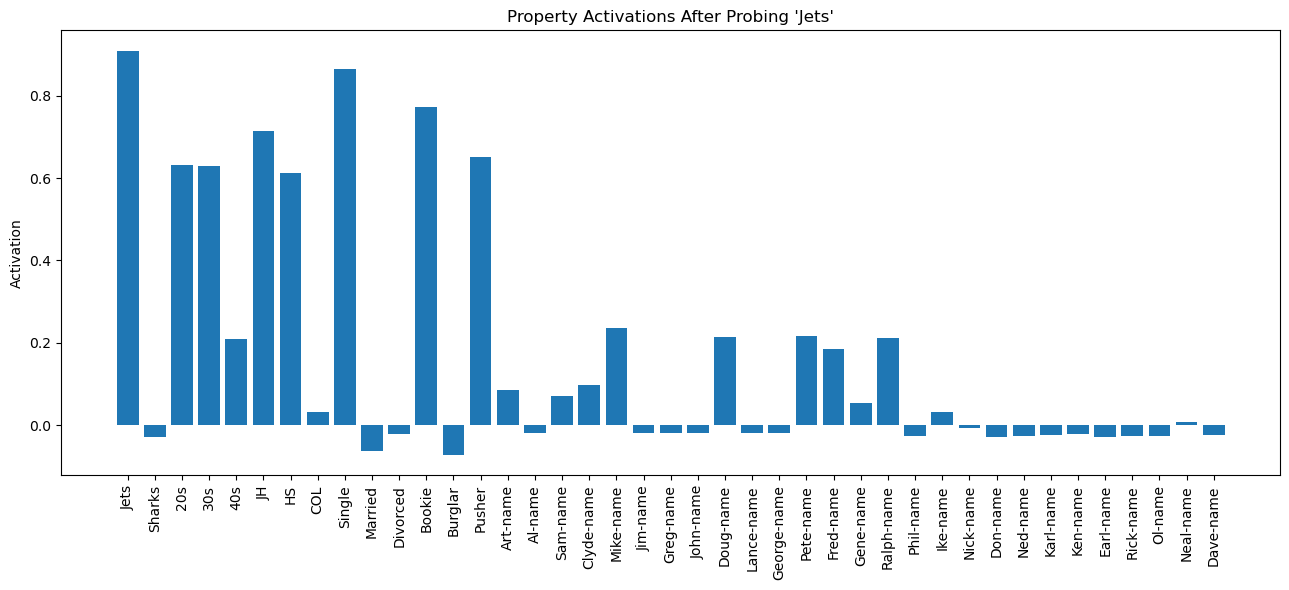

In [6]:
# Probing Jets
probe = np.zeros(68)
probe[27] = 0.2  # 'Jets'

model1 = IACModel(excitatory_matrix, inhibitory_matrix)
activation_values = model1.run(external_input=probe, timesteps=500)
final_activation = activation_values[-1]

# Print activation values for selected nodes
target_labels = ['Jets', '20s', 'JH', 'Single', 'Pusher', 'Burglar', 'Bookie']

print("Activation values for selected nodes after probing 'Jets':\n")
for label in target_labels:
    if label in node_names:
        index = node_names.index(label)
        print(f"{label}: {final_activation[index]:.3f}")
    else:
        print(f"{label}: not found in node list")

property_indices = list(range(27, 68))
property_labels = [node_names[i] for i in property_indices]
property_values = final_activation[property_indices]

plt.figure(figsize=(13,6))
plt.bar(property_labels, property_values)
plt.xticks(rotation=90)
plt.title("Property Activations After Probing 'Jets'")
plt.ylabel('Activation')
plt.tight_layout()
plt.savefig('probe_jets.png')
plt.show()

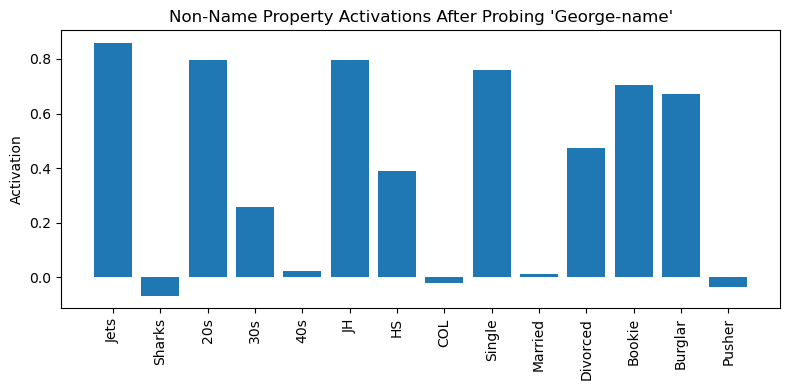

In [7]:
# Probing George-name
probe = np.zeros(68)
probe[51] = 0.2  # 'George-name'

model2 = IACModel(excitatory_matrix, inhibitory_matrix)
activation_values = model2.run(external_input=probe, timesteps=500)
final_activation = activation_values[-1]


non_name_property_indices = list(range(27, 41))
property_labels = [node_names[i] for i in non_name_property_indices]
property_values = final_activation[non_name_property_indices]

plt.figure(figsize=(8, 4))
plt.bar(property_labels, property_values)
plt.xticks(rotation=90)
plt.title("Non-Name Property Activations After Probing 'George-name'")
plt.ylabel('Activation')
plt.tight_layout()
plt.savefig('probe_george-name.png')
plt.show()


Activation values for selected nodes after probing '20s and JH':

Lance: 0.697
Jim: 0.688
John: 0.697
George: 0.688
Jets: 0.858
20s: 0.897
JH: 0.903
Married: 0.479
Divorced: 0.410
Burglar: 0.757


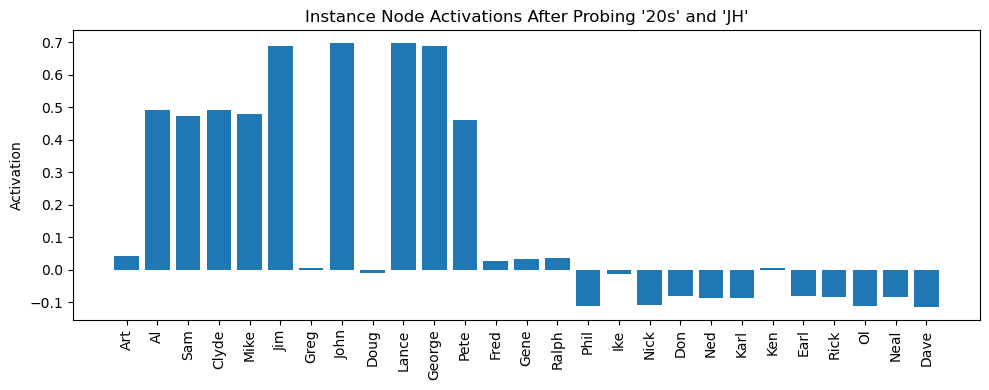

In [8]:
# Probing Age 20s and JH
probe = np.zeros(68)
probe[29] = 0.2  # '20s'
probe[32] = 0.2  # 'JH'

model3 = IACModel(excitatory_matrix, inhibitory_matrix)
activation_values = model3.run(external_input=probe, timesteps=500)
final_activation = activation_values[-1]

# Print activation values for selected nodes
target_labels = ['Lance', 'Jim', 'John', 'George', 'Jets', '20s', 'JH', 'Married','Divorced','Burglar']

print("Activation values for selected nodes after probing '20s and JH':\n")
for label in target_labels:
    if label in node_names:
        index = node_names.index(label)
        print(f"{label}: {final_activation[index]:.3f}")
    else:
        print(f"{label}: not found in node list")

instance_indices = list(range(27))  # Instance nodes: 0 to 26
instance_labels = [node_names[i] for i in instance_indices]
instance_values = final_activation[instance_indices]

plt.figure(figsize=(10, 4))
plt.bar(instance_labels, instance_values)
plt.xticks(rotation=90)
plt.title("Instance Node Activations After Probing '20s' and 'JH'")
plt.ylabel('Activation')
plt.tight_layout()
plt.savefig('probe_20s_JH.png')
plt.show()


## Comparison of IACModel and McClelland (1981)

In the section below, we will compare the values that were computed by the IAC model above with the values computed by McClelland in his 1981 paper.

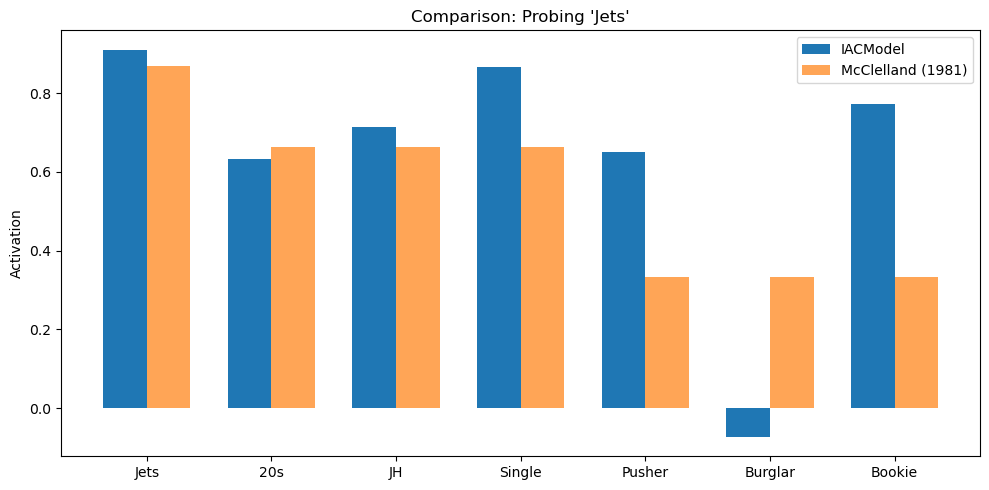

In [9]:
# Probe "Jets"
probe = np.zeros(68)
probe[27] = 0.2  # 'Jets'

model = IACModel(excitatory_matrix, inhibitory_matrix)
activation_values = model.run(external_input=probe, timesteps=500)
final_activation = activation_values[-1]

labels_jets = ['Jets', '20s', 'JH', 'Single', 'Pusher', 'Burglar', 'Bookie']
model_jets = {label: final_activation[node_names.index(label)] for label in labels_jets}


#Values from McClelland (1981)
paper_jets = {
    'Jets': 0.869,
    '20s': 0.663,
    'JH': 0.663,
    'Single': 0.663,
    'Pusher': 0.334,
    'Burglar': 0.334,
    'Bookie': 0.334
}


model_vals_jets = [model_jets[k] for k in labels_jets]
paper_vals_jets = [paper_jets[k] for k in labels_jets]

x = np.arange(len(labels_jets))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, model_vals_jets, width, label='IACModel')
plt.bar(x + width/2, paper_vals_jets, width, label='McClelland (1981)', alpha=0.7)
plt.xticks(x, labels_jets)
plt.ylabel('Activation')
plt.title("Comparison: Probing 'Jets'")
plt.legend()
plt.tight_layout()
plt.savefig("comparison_jets_probe.png")
plt.show()


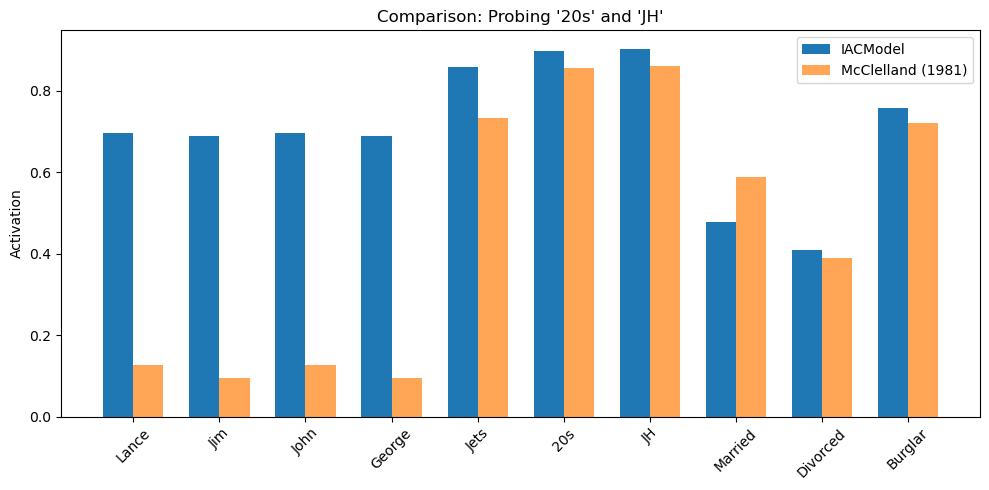

In [10]:
# Probe with '20s' and 'JH'
probe = np.zeros(68)
probe[29] = 0.2  # '20s'
probe[32] = 0.2  # 'JH'

model = IACModel(excitatory_matrix, inhibitory_matrix)
activation_values = model.run(external_input=probe, timesteps=500)
final_activation = activation_values[-1]

labels_20s_jh = ['Lance', 'Jim', 'John', 'George', 'Jets', '20s', 'JH', 'Married', 'Divorced', 'Burglar']
IACmodel_20s_jh = {label: final_activation[node_names.index(label)] for label in labels_20s_jh}

paper_20s_jh = {
    'Lance': 0.127,
    'Jim': 0.094,
    'John': 0.127,
    'George': 0.094,
    'Jets': 0.732,
    '20s': 0.855,
    'JH': 0.862,
    'Married': 0.589,
    'Divorced': 0.389,
    'Burglar': 0.721
}

model_vals_20s_jh = [IACmodel_20s_jh[k] for k in labels_20s_jh]
paper_vals_20s_jh = [paper_20s_jh[k] for k in labels_20s_jh]

x = np.arange(len(labels_20s_jh))
width = 0.35

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, model_vals_20s_jh, width, label='IACModel')
plt.bar(x + width/2, paper_vals_20s_jh, width, label='McClelland (1981)', alpha=0.7)
plt.xticks(x, labels_20s_jh, rotation=45)
plt.ylabel('Activation')
plt.title("Comparison: Probing '20s' and 'JH'")
plt.legend()
plt.tight_layout()
plt.savefig("comparison_20s_JH_probe.png")
plt.show()

## Conclusion
Well done! You have implemented McClellands original IAC network, the (re-)birth of connectionism and artificial neural networks!